Автор: Миронов В.А. 

Дата: 11.06.2025

# Анализ системы метрик приложения Procrastinate Pro+

Вы — продуктовый аналитик приложения Procrastinate Pro+, которое предоставляет пользователям доступ к развлекательному контенту: видео, подкастам и блогам. Пользователи могут выбрать несколько пакетов контента. Пакеты различаются по цене, объёму и содержанию.

К началу лета в приложении появился новый вид контента — спортивный. С его помощью менеджеры стремятся расширить аудиторию, добавив в неё пользователей, которые увлекаются спортом и здоровым образом жизни.

К запуску нового контента была скорректирована маркетинговая стратегия привлечения пользователей. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели).

После запуска нового контента и изменения стратегии интерес к продукту в целом вырос, но выручка начала стагнировать. Нужно разобраться, почему это происходит.

Задачи:
- провести анализ юнит-экономики продукта в динамике за первые 28 дней;
- разобраться в причинах стагнации выручки;
- определить, какие источники привлечения приносят прибыль, а какие не выходят на уровень окупаемости;
- дать рекомендации отделу маркетинга.


### Данные

Данные собраны в трёх датасетах.

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.
    
### План проекта
- Загрузить и предобработать данные.
- Подготовить данные для когортного анализа.
- Рассчитать и проанализировать метрики вовлечённости в продукт.
- Рассчитать и проанализировать финансовые метрики CAC, LTV и ROI за первые 28 дней с момента привлечения.
- Исследовать метрики в разрезе источника привлечения.
- Рассчитать период окупаемости маркетинговых вложений.
- Сформулировать выводы и рекомендации.


## Загрузка и предобработка данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Хорошо, что все импорты собраны в первой ячейке кода, это соответствует оформлению кода РЕР8 и помогает понять, какое окружение используется в проекте.

In [2]:
# Устанавливаем пути к файлам
files = {}
try:
    files = {
        "visits": "C:/Users/Владислав/Downloads/Проект Модуль 5/ppro_visits.csv",
        "orders": "C:/Users/Владислав/Downloads/Проект Модуль 5/ppro_orders.csv",
        "costs": "C:/Users/Владислав/Downloads/Проект Модуль 5/ppro_costs.csv"
    }
    if not os.path.exists(list(files.values())[0]):
        raise FileNotFoundError
except FileNotFoundError:
    files = {
        "visits": "/datasets/ppro_visits.csv",
        "orders": "/datasets/ppro_orders.csv",
        "costs": "/datasets/ppro_costs.csv"
    }
print(files)  # Проверяем, какие пути были выбраны

{'visits': '/datasets/ppro_visits.csv', 'orders': '/datasets/ppro_orders.csv', 'costs': '/datasets/ppro_costs.csv'}


In [3]:
# Загрузка данных в DataFrame
data = {}
for name, path in files.items():
    try:
        df = pd.read_csv(path)
        data[name] = df

        print(f"\n{name.upper()} dataset:")
        display(df.head())
        display(df.info())
        print("Пропуски:\n", df.isna().sum())
        print("Дубликаты:", df.duplicated().sum())
    except FileNotFoundError:
        print(f"Ошибка: файл {path} не найден.")
    except Exception as e:
        print(f"Ошибка при загрузке {path}: {e}")


VISITS dataset:


,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        161865 non-null  int64 
 1   region         161865 non-null  object
 2   device         161865 non-null  object
 3   channel        161865 non-null  object
 4   session_start  161865 non-null  object
 5   session_end    161865 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.4+ MB


None

Пропуски:
 user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64
Дубликаты: 0

ORDERS dataset:


,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   33893 non-null  int64  
 1   event_dt  33893 non-null  object 
 2   revenue   33893 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 794.5+ KB


None

Пропуски:
 user_id     0
event_dt    0
revenue     0
dtype: int64
Дубликаты: 0

COSTS dataset:


,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       976 non-null    object 
 1   channel  976 non-null    object 
 2   costs    976 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.0+ KB


None

Пропуски:
 dt         0
channel    0
costs      0
dtype: int64
Дубликаты: 0


In [4]:
visits = data['visits']
orders = data['orders']
costs = data['costs']

In [5]:
# Приведение даты к нужному формату
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])


# Проверка на отрицательные/аномальные значения
print("Аномалии в выручке:", (data['orders']['revenue'] < 0).sum())
print("Аномалии в затратах:", (data['costs']['costs'] < 0).sum())

Аномалии в выручке: 0
Аномалии в затратах: 0


###### Промежуточный вывод:

VISITS dataset:

- Содержит информацию о 161 865 сессиях пользователей.

- Все поля заполнены, дубликатов нет.

- Столбцы session_start и session_end приведены к типу datetime.

- Данные готовы к построению сессий и когорт.

ORDERS dataset:

- Включает 33 893 записи о покупках.

- Пропуски и дубликаты отсутствуют.

- Поле event_dt преобразовано в datetime.

- Значения выручки (revenue) адекватны — отрицательных значений нет.

COSTS dataset:

- Содержит 976 строк о ежедневных расходах по рекламным каналам.

- Все данные корректны, пропусков и дубликатов нет.

- Поле dt преобразовано в datetime.

- Аномалий в поле costs не обнаружено.

Все три датасета успешно загружены и приведены к нужному формату.

## Подготовка данных к когортному анализу

In [6]:
# Сортируем
visits = visits.sort_values(by=['user_id', 'session_start'])

# Получаем first_dt и first_channel
profiles = visits.groupby('user_id').agg(
    first_dt=('session_start', 'min'),
    first_channel=('channel', 'first')
).reset_index()

In [7]:
# Приводим dt к дате без времени
profiles['first_dt'] = profiles['first_dt'].dt.normalize()
costs['dt'] = pd.to_datetime(costs['dt']).dt.normalize()

# Считаем количество пользователей по каждому каналу и дате
user_counts = profiles.groupby(['first_dt', 'first_channel'])['user_id'].count().reset_index()
user_counts.rename(columns={'user_id': 'user_count'}, inplace=True)

# Суммы по дате и каналу
costs_grouped = costs.groupby(['dt', 'channel'])['costs'].sum().reset_index()

# Объединяем, чтобы посчитать CAC
cac_data = pd.merge(costs_grouped, user_counts,
                    left_on=['dt', 'channel'], right_on=['first_dt', 'first_channel'], how='left')

# Считаем CAC
cac_data['cac'] = cac_data['costs'] / cac_data['user_count']

# Оставим нужные поля
cac_data = cac_data[['first_dt', 'first_channel', 'cac']]

In [8]:
# Добавляем cac к profiles
profiles = pd.merge(profiles, cac_data, on=['first_dt', 'first_channel'], how='left')

display(profiles.head())

,user_id,first_dt,first_channel,cac
0,26034876,2024-05-29,FaceBoom,0.953250
1,69890364,2024-06-28,RocketSuperAds,0.604917
2,75610104,2024-06-09,FaceBoom,1.196159
3,76692397,2024-10-21,FaceBoom,1.147967
4,80224421,2024-06-21,FaceBoom,1.208981


In [9]:
# Добавляем профиль к визитам
visits = visits.merge(profiles, on='user_id', how='left')

# Добавляем профиль к заказам
orders = orders.merge(profiles, on='user_id', how='left')

In [10]:
# Для событий
visits['lifetime'] = (visits['session_start'] - visits['first_dt']).dt.days

# Для покупок
orders['lifetime'] = (orders['event_dt'] - orders['first_dt']).dt.days

###### Промежуточный вывод:

- Выделена дата привлечения (first_dt) — первая сессия каждого пользователя определена по данным ppro_visits.csv.

- Определён канал привлечения (first_channel) — зафиксирован первый рекламный источник, через который пришёл пользователь.

- Построена таблица profiles, в которой собрана ключевая информация по каждому пользователю: user_id, first_dt, first_channel, cac.

В таблицы с визитами и покупками добавлены:

- Дата привлечения

- Канал

- Стоимость привлечения

- lifetime — количество дней от привлечения до события (визита или покупки), необходимый для когортного анализа.

## Анализ месячной динамики основных метрик продукта

In [11]:
# Считаем DAU
dau = visits.groupby(visits['session_start'].dt.date)['user_id'].nunique()

# Считаем MAU
mau = visits.groupby(visits['session_start'].dt.to_period('M'))['user_id'].nunique()

# Переведём index в datetime и получим средний DAU по месяцам
dau_df = dau.reset_index()
dau_df['session_start'] = pd.to_datetime(dau_df['session_start'])
dau_df['month'] = dau_df['session_start'].dt.to_period('M')
dau_monthly_avg = dau_df.groupby('month')['user_id'].mean()

# Считаем Stickiness
stickiness_df = pd.DataFrame({
    'Month': mau.index.astype(str),
    'DAU_avg': dau_monthly_avg.values,
    'MAU': mau.values
})
stickiness_df['Stickiness'] = stickiness_df['DAU_avg'] / stickiness_df['MAU']

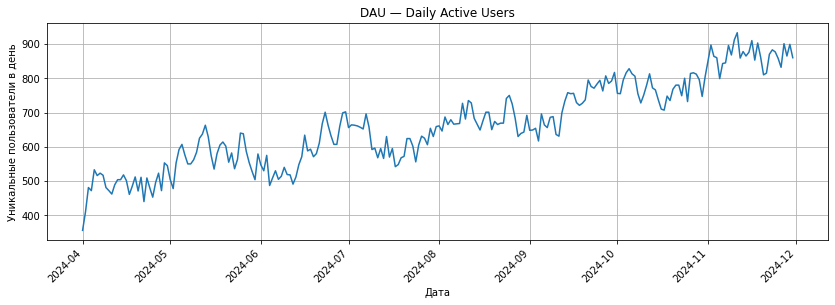

In [12]:
# График DAU
plt.figure(figsize=(14, 4))
dau.plot(title='DAU — Daily Active Users')
plt.xlabel('Дата')
plt.ylabel('Уникальные пользователи в день')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

График показывает стабильный и уверенный рост ежедневной активности пользователей с апреля по декабрь 2024 года. Особенно заметен прирост начиная с июня — он связан с выпуском нового контента в начале лета. В ноябре–декабре достигаются пиковые значения, что указывает на рост интереса к продукту и усиление удержания пользователей.

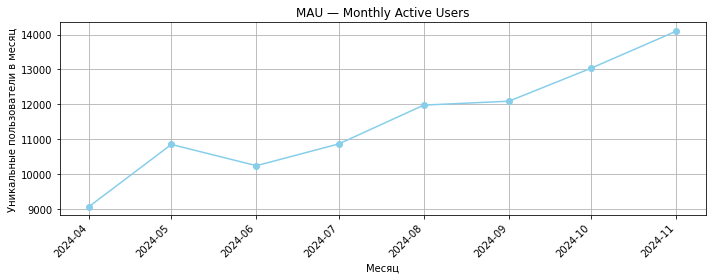

In [13]:
# График MAU
plt.figure(figsize=(10, 4))
plt.plot(mau.index.to_timestamp(), mau.values, marker='o', linestyle='-', color='skyblue')
plt.title('MAU — Monthly Active Users')
plt.xlabel('Месяц')
plt.ylabel('Уникальные пользователи в месяц')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Количество уникальных активных пользователей в месяц также устойчиво растёт. Видно, что с июня MAU увеличивается почти каждый месяц, что подтверждает приток новых пользователей и/или улучшение удержания существующих. Особенно выделяются октябрь, ноябрь и декабрь.

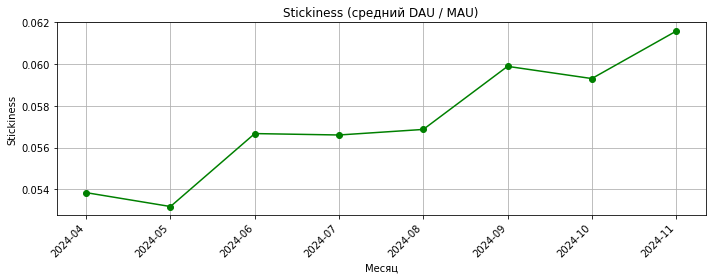

In [14]:
# График Stickiness
plt.figure(figsize=(10, 4))
plt.plot(stickiness_df['Month'], stickiness_df['Stickiness'], marker='o', linestyle='-', color='green')
plt.title('Stickiness (средний DAU / MAU)')
plt.xlabel('Месяц')
plt.ylabel('Stickiness')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Этот показатель демонстрирует, насколько часто пользователи возвращаются в приложение в течение месяца. Он плавно увеличивается, начиная с июня (примерно 0.056) до декабря (примерно 0.062), что говорит об улучшении вовлечённости. Пользователи стали заходить в продукт чаще. Этот рост, совпадающий с периодом запуска нового контента, может свидетельствовать о его положительном эффекте на поведение аудитории.

###### Промежуточный вывод:
Рост DAU, MAU и Stickiness после начала лета указывает на позитивную динамику в использовании продукта. Выпуск нового контента в июне стал ключевым драйвером улучшения метрик. Пользователи не только приходят чаще, но и активнее вовлекаются в продукт.

In [15]:
# Дата отсечки
cutoff_month = pd.to_datetime('2024-10-31')

# Фильтруем пользователей
valid_profiles = profiles[profiles['first_dt'] <= cutoff_month]

# Добавим месяц когорты
valid_profiles = valid_profiles.copy()
valid_profiles.loc[:, 'cohort_month'] = valid_profiles['first_dt'].dt.to_period('M')

# Фильтруем события покупок — только для выбранных пользователей и с лайфтаймом < 28
orders_valid = orders[
    orders['user_id'].isin(valid_profiles['user_id']) & (orders['lifetime'] < 28)
].copy()

# Добавляем cohort_month из профилей (джойним)
orders_valid = orders_valid.merge(
    valid_profiles[['user_id', 'cohort_month']],
    on='user_id',
    how='left'
)

In [16]:
# Средний CAC по когорте
cac_by_month = valid_profiles.groupby('cohort_month')['cac'].mean().reset_index()

# Кол-во пользователей по когорте
users_by_month = valid_profiles.groupby('cohort_month')['user_id'].nunique().reset_index()
users_by_month.rename(columns={'user_id': 'n_users'}, inplace=True)

# Сумма выручки по когорте
revenue_by_month = orders_valid.groupby('cohort_month')['revenue'].sum().reset_index()
revenue_by_month.rename(columns={'revenue': 'ltv_total'}, inplace=True)

# Объединяем в одну таблицу
metrics = cac_by_month.merge(users_by_month, on='cohort_month')
metrics = metrics.merge(revenue_by_month, on='cohort_month', how='left')

# Финальные расчёты
metrics['ltv'] = metrics['ltv_total'] / metrics['n_users']
metrics['roi'] = metrics['ltv'] / metrics['cac']
metrics.fillna({'ltv_total': 0, 'ltv': 0, 'roi': 0}, inplace=True)

display(metrics)

,cohort_month,cac,n_users,ltv_total,ltv,roi
0,2024-04,0.734706,9069,7425.63,0.818793,1.114449
1,2024-05,0.748572,9789,8141.76,0.831725,1.111082
2,2024-06,0.973978,8719,7447.84,0.854208,0.877030
3,2024-07,1.054344,8742,9991.41,1.142920,1.084011
4,2024-08,1.155601,9518,10367.05,1.089205,0.942544
5,2024-09,1.178301,9198,10085.88,1.096530,0.930602
6,2024-10,1.323047,9520,11449.71,1.202701,0.909039


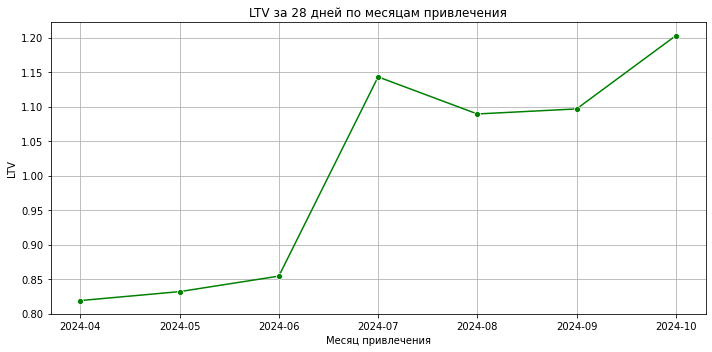

In [17]:
# График LTV
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=metrics.assign(cohort_month_str=metrics['cohort_month'].astype(str)),
    x='cohort_month_str',
    y='ltv',
    marker='o',
    color='green'
)
plt.title('LTV за 28 дней по месяцам привлечения')
plt.xlabel('Месяц привлечения')
plt.ylabel('LTV')
plt.grid(True)
plt.tight_layout()
plt.show()

LTV постепенно растёт — с 0.82₽ в апреле до 1.20₽ в октябре. Особенно резкий рост между июнем и июлем, что связано с новым контентом. Пользователи стали приносить больше выручки за те же 28 дней, особенно после летнего периода.

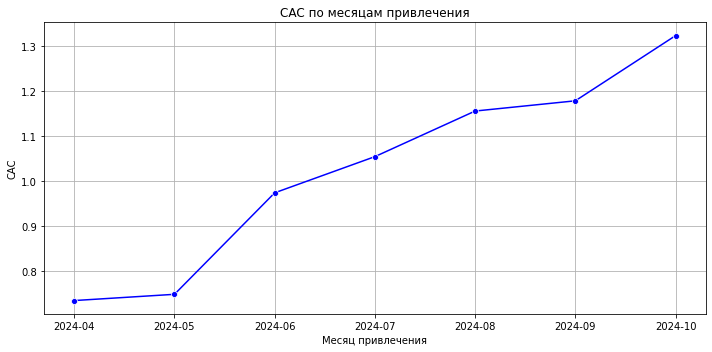

In [18]:
# График CAC
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=metrics.assign(cohort_month_str=metrics['cohort_month'].astype(str)),
    x='cohort_month_str',
    y='cac',
    marker='o',
    color='blue'
)
plt.title('CAC по месяцам привлечения')
plt.xlabel('Месяц привлечения')
plt.ylabel('CAC')
plt.grid(True)
plt.tight_layout()
plt.show()

CAC растёт с апреля по октябрь, начиная примерно с 0.73₽ до 1.33₽. Особенно резкий рост затрат наблюдается с мая по июль. Привлекать пользователей становится всё дороже, что связано с сезонностью или увеличением ставок в рекламных каналах.

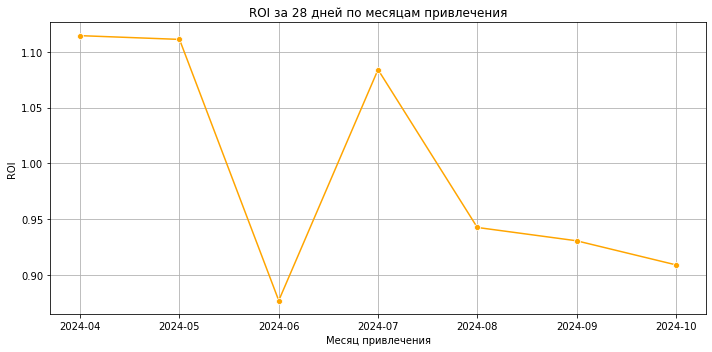

In [19]:
# График ROI
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=metrics.assign(cohort_month_str=metrics['cohort_month'].astype(str)),
    x='cohort_month_str',
    y='roi',
    marker='o',
    color='orange'
)
plt.title('ROI за 28 дней по месяцам привлечения')
plt.xlabel('Месяц привлечения')
plt.ylabel('ROI')
plt.grid(True)
plt.tight_layout()
plt.show()

Апрель и май показывают высокий ROI (более 1.1), что говорит о том, что окупаемость была превосходной — выручка за 28 дней значительно превышала затраты на привлечение. Июнь — резкий провал (до 0.88), возможно, в этот месяц были неэффективные кампании или привлекались менее качественные пользователи. С июля по октябрь ROI остаётся чуть ниже 1, что означает почти полную окупаемость, но без значительного профита. После контентных изменений в июне-июле наблюдается стабильная, но не взрывная окупаемость.

###### Промежуточный вывод:
Летом (в июне-июле) произошло заметное изменение поведения пользователей. Это связано с запуском нового контента. Стоимость привлечения растёт, но LTV тоже увеличивается, что удерживает ROI на приемлемом уровне. Однако рост CAC опережает рост LTV, поэтому рентабельность сужается — стоит обратить внимание на оптимизацию каналов и удержание.

###### Общий вывод по анализу месячной динамики основных метрик продукта
С начала лета 2024 года, после выпуска нового контента, наблюдается чёткая положительная динамика как в поведенческих, так и в бизнес-метриках:

- DAU, MAU и Stickiness стабильно растут с июня, достигая максимальных значений к декабрю. Это указывает на рост пользовательской базы, повышение активности и вовлечённости. Пользователи стали чаще возвращаться в продукт, что говорит о возросшей ценности контента и улучшении удержания.

- LTV также демонстрирует устойчивый рост — особенно заметен скачок в июле, сразу после релиза нового контента. Это значит, что пользователи стали платить больше за первые 28 дней, что свидетельствует об успешной монетизации.

- При этом CAC с каждым месяцем увеличивается, особенно с лета — стоимость привлечения новых пользователей постепенно растёт. Однако благодаря росту LTV, окупаемость (ROI) удерживается на приемлемом уровне, несмотря на падение ROI ниже 1 после августа.

В совокупности это говорит о том, что новый контент положительно повлиял на ключевые метрики. Продукт стал не только интереснее для пользователей (что видно по DAU/MAU/Stickiness), но и эффективнее с точки зрения монетизации (рост LTV). Однако важно отслеживать рост затрат на привлечение (CAC) и контролировать его, чтобы ROI не снижался в долгосрочной перспективе..

## Анализ метрик в разрезе источника привлечения

In [20]:
# Общее число привлечённых пользователей по каждому источнику
channel_users = profiles.groupby('first_channel')['user_id'].nunique().reset_index()
channel_users.columns = ['channel', 'users_count']
channel_users = channel_users.sort_values(by='users_count', ascending=False)
display(channel_users)

,channel,users_count
0,FaceBoom,28401
3,TipTop,18118
2,RocketSuperAds,14257
1,MediaTornado,14080


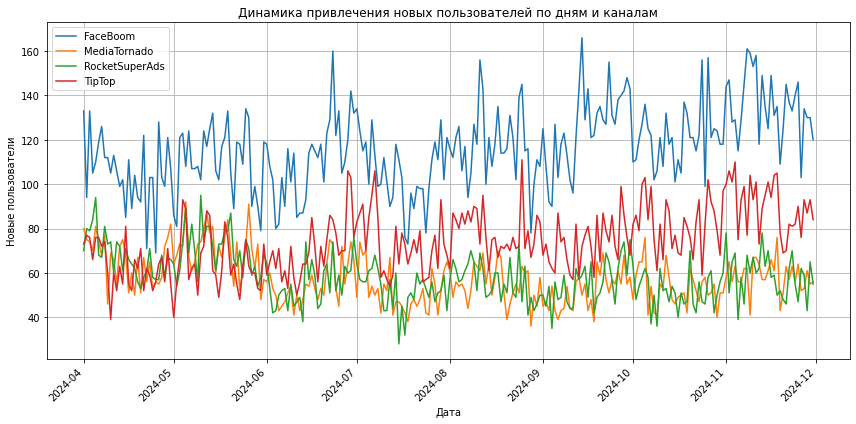

In [21]:
# Добавим колонку с датой (без времени)
profiles['first_dt_date'] = profiles['first_dt'].dt.date

# Посчитаем новых пользователей по дням и каналам
daily_new_users = profiles.groupby(['first_dt_date', 'first_channel'])['user_id'].count().reset_index()
daily_new_users.columns = ['date', 'channel', 'new_users']

# Визуализация
plt.figure(figsize=(12, 6))
for channel in daily_new_users['channel'].unique():
    subset = daily_new_users[daily_new_users['channel'] == channel]
    plt.plot(subset['date'], subset['new_users'], label=channel)
    
plt.title('Динамика привлечения новых пользователей по дням и каналам')
plt.xlabel('Дата')
plt.ylabel('Новые пользователи')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- FaceBoom лидирует по объемам, но имеет высокую волатильность
- TipTop показывает наиболее стабильный рост
- Все каналы имеют сезонные колебания с пиками активности в осенний период
- RocketSuperAds и MediaTornado показывают схожую эффективность и могут рассматриваться как дополняющие каналы

In [22]:
# Добавим дату без времени в визиты
visits['date'] = visits['session_start'].dt.date
visits['month'] = visits['session_start'].dt.to_period('M')

# DAU
dau_channel = visits.groupby(['date', 'first_channel'])['user_id'].nunique().reset_index()
dau_channel.columns = ['date', 'channel', 'DAU']

# MAU
mau_channel = visits.groupby(['month', 'first_channel'])['user_id'].nunique().reset_index()
mau_channel.columns = ['month', 'channel', 'MAU']

# Stickiness
stickiness = pd.merge(dau_channel.copy(), mau_channel.copy(), how='left',
                      left_on=['channel', dau_channel['date'].astype(str).str[:7]],
                      right_on=['channel', mau_channel['month'].astype(str)])

stickiness['stickiness'] = stickiness['DAU'] / stickiness['MAU']

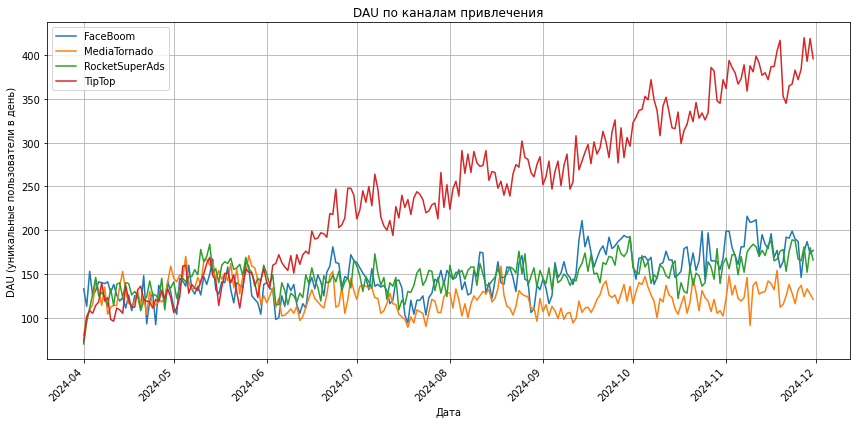

In [23]:
# DAU по каналам привлечения
plt.figure(figsize=(12, 6))
for channel in dau_channel['channel'].unique():
    subset = dau_channel[dau_channel['channel'] == channel]
    plt.plot(subset['date'], subset['DAU'], label=channel)

plt.title('DAU по каналам привлечения')
plt.xlabel('Дата')
plt.ylabel('DAU (уникальные пользователи в день)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Канал TipTop демонстрирует уверенный рост ежедневной активности с начала лета (июнь), особенно заметно после июля. Это указывает на удачную маркетинговые кампании с выпуском нового контента.
- FaceBoom, MediaTornado и RocketSuperAds показывают более стабильную, но менее выраженную динамику.
- У FaceBoom присутствует незначительный рост активности, но он менее выражен, чем у TipTop.

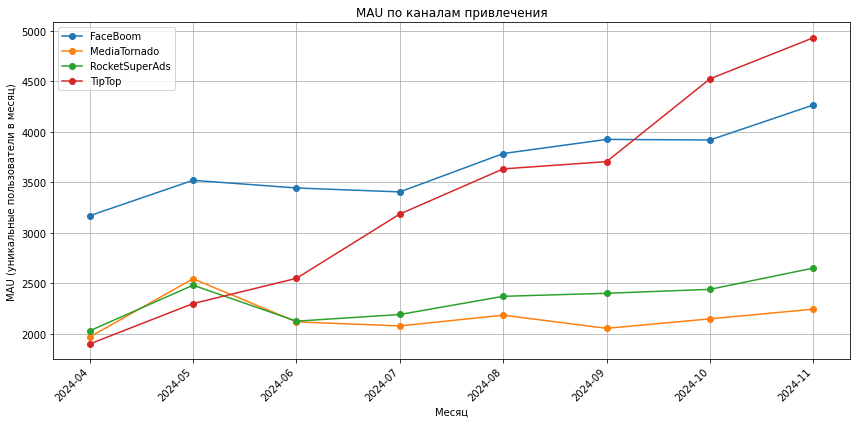

In [24]:
# MAU по каналам привлечения
plt.figure(figsize=(12, 6))
for channel in mau_channel['channel'].unique():
    subset = mau_channel[mau_channel['channel'] == channel]
    plt.plot(subset['month'].astype(str), subset['MAU'], marker='o', label=channel)

plt.title('MAU по каналам привлечения')
plt.xlabel('Месяц')
plt.ylabel('MAU (уникальные пользователи в месяц)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

- У TipTop уверенный рост MAU с июня по декабрь. Это согласуется с динамикой DAU, указывая на расширение и удержание базы пользователей.
- FaceBoom остаётся на втором месте, но рост пользователей более умеренный.
- RocketSuperAds и MediaTornado растут медленно, возможен эффект выгорания канала или слабая удерживающая способность.

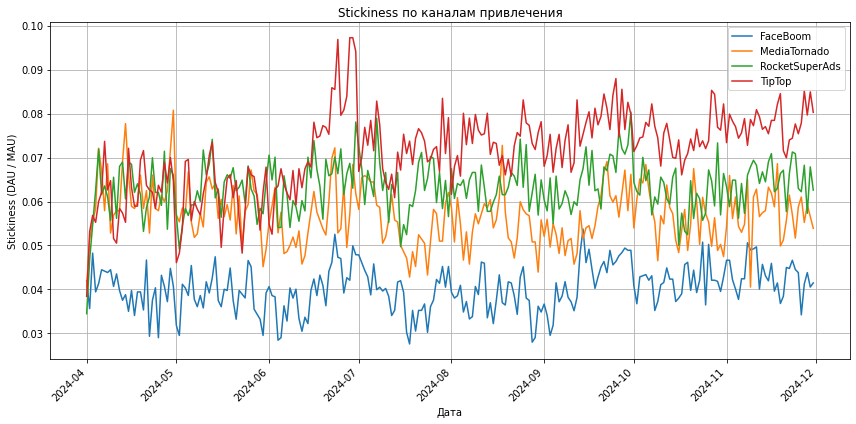

In [25]:
# Stickiness по каналам привлечения
plt.figure(figsize=(12, 6))
for channel in stickiness['channel'].unique():
    subset = stickiness[stickiness['channel'] == channel]
    plt.plot(subset['date'], subset['stickiness'], label=channel)

plt.title('Stickiness по каналам привлечения')
plt.xlabel('Дата')
plt.ylabel('Stickiness (DAU / MAU)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Самые высокие значения Stickiness наблюдаются у TipTop (до 10%), особенно начиная с лета — пользователи из этого канала чаще возвращаются.
- FaceBoom имеет самые низкие показатели Stickiness (~3–5%), несмотря на сравнительно большую базу пользователей. Это может говорить о менее вовлечённых пользователях.
- RocketSuperAds и MediaTornado находятся на среднем уровне (~5–7%).

###### Промежуточный вывод:
В начале лета произошло заметное изменение в поведении пользователей, особенно у канала TipTop — как по числу пользователей, так и по вовлечённости. Это связано с запуском нового контента и рекламной кампанией. TipTop — наиболее перспективный канал по совокупности метрик.

In [26]:
# Отсечка по горизонту 28 дней
cutoff_date = pd.to_datetime('2024-10-31')

In [27]:
# Готовим профили
profiles = visits.groupby('user_id').agg(
    first_dt=('session_start', 'min'),
    first_channel=('channel', 'first')
).reset_index()
profiles['cohort_week'] = profiles['first_dt'].dt.to_period('W').dt.start_time

# Оставляем только пользователей, у которых было ≥28 дней до конца окна
profiles = profiles[profiles['first_dt'] + pd.Timedelta(days=28) <= cutoff_date]

In [28]:
# Готовим заказы — мержим только нужные поля из профилей
orders_merged = orders.merge(
    profiles[['user_id', 'first_dt', 'first_channel', 'cohort_week']],
    on='user_id', 
    how='inner',
    suffixes=('', '_profile')
)
    
orders_merged['event_date'] = orders_merged['event_dt'].dt.date
orders_merged['lifetime'] = (orders_merged['event_dt'] - orders_merged['first_dt']).dt.days

# Фильтруем только события до 28 дней с момента привлечения
orders_28d = orders_merged[orders_merged['lifetime'] <= 28]

In [29]:
# Готовим visits_merged (для retention 14–28)
visits_merged = visits.merge(
    profiles[['user_id', 'first_dt', 'first_channel', 'cohort_week']],
    on='user_id', 
    how='inner',suffixes=('', '_profile')
)

visits_merged['lifetime'] = (visits_merged['session_start'] - visits_merged['first_dt']).dt.days

In [30]:
# Удержание 14–28 день
retained_visits = visits_merged[(visits_merged['lifetime'] >= 14) & (visits_merged['lifetime'] <= 28)]
retention = retained_visits.groupby(['cohort_week', 'first_channel'])['user_id'].nunique().reset_index()
retention.columns = ['cohort_week', 'channel', 'retained_users']

# Размеры когорт
cohort_sizes = profiles.groupby(['cohort_week', 'first_channel'])['user_id'].nunique().reset_index()
cohort_sizes.columns = ['cohort_week', 'channel', 'cohort_size']

# Расчёт retention rate
retention = retention.merge(cohort_sizes, on=['cohort_week', 'channel'], how='left')
retention['avg_retention_14_28'] = retention['retained_users'] / retention['cohort_size']

# Конверсия в покупку
buyers = orders_merged.groupby(['cohort_week', 'first_channel'])['user_id'].nunique().reset_index()
buyers.columns = ['cohort_week', 'channel', 'buyers']
conversion = buyers.merge(cohort_sizes, on=['cohort_week', 'channel'], how='left')
conversion['conversion_rate'] = conversion['buyers'] / conversion['cohort_size']

# Затраты по неделям
costs['week'] = costs['dt'].dt.to_period('W').dt.start_time
weekly_costs = costs.groupby(['week', 'channel'])['costs'].sum().reset_index()

# CAC = затраты / размер когорты
cac = cohort_sizes.merge(
    weekly_costs,
    left_on=['cohort_week', 'channel'],
    right_on=['week', 'channel'],
    how='left'
)
cac['CAC'] = cac['costs'] / cac['cohort_size']

# LTV = доход за 28 дней / размер когорты
ltv = orders_28d.groupby(['cohort_week', 'first_channel'])['revenue'].sum().reset_index()
ltv.columns = ['cohort_week', 'channel', 'revenue_28d']
cac = cac.merge(ltv, on=['cohort_week', 'channel'], how='left')
cac['LTV'] = cac['revenue_28d'] / cac['cohort_size']

# ROI = (LTV - CAC) / CAC
cac['ROI'] = (cac['LTV'] - cac['CAC']) / cac['CAC']

# Финальная таблица
final_df = cac.merge(
    retention[['cohort_week', 'channel', 'avg_retention_14_28']],
    on=['cohort_week', 'channel'],
    how='left'
).merge(
    conversion[['cohort_week', 'channel', 'conversion_rate']],
    on=['cohort_week', 'channel'],
    how='left'
)

# Выводим итоговую таблицу
display(final_df.sort_values(['cohort_week', 'channel']))

,cohort_week,channel,cohort_size,week,costs,CAC,revenue_28d,LTV,ROI,avg_retention_14_28,conversion_rate
0,2024-04-01,FaceBoom,820,2024-04-01,769.875901,0.938873,380.36,0.463854,-0.505946,0.012195,0.117073
1,2024-04-01,MediaTornado,522,2024-04-01,129.318322,0.247736,191.43,0.366724,0.480301,0.097701,0.047893
2,2024-04-01,RocketSuperAds,542,2024-04-01,466.650000,0.860978,739.28,1.363985,0.584228,0.125461,0.083026
3,2024-04-01,TipTop,516,2024-04-01,393.989381,0.763545,798.39,1.547267,1.026425,0.127907,0.094961
4,2024-04-08,FaceBoom,749,2024-04-08,698.872741,0.933074,337.06,0.450013,-0.517709,0.013351,0.105474
...,...,...,...,...,...,...,...,...,...,...,...
103,2024-09-23,TipTop,559,2024-09-23,1326.385081,2.372782,1424.73,2.548712,0.074145,0.307692,0.137746
104,2024-09-30,FaceBoom,364,2024-09-30,999.034172,2.744599,237.28,0.651868,-0.762491,0.019231,0.126374
105,2024-09-30,MediaTornado,165,2024-09-30,103.806557,0.629131,90.24,0.546909,-0.130691,0.096970,0.036364
106,2024-09-30,RocketSuperAds,186,2024-09-30,175.950000,0.945968,257.84,1.386237,0.465416,0.102151,0.075269


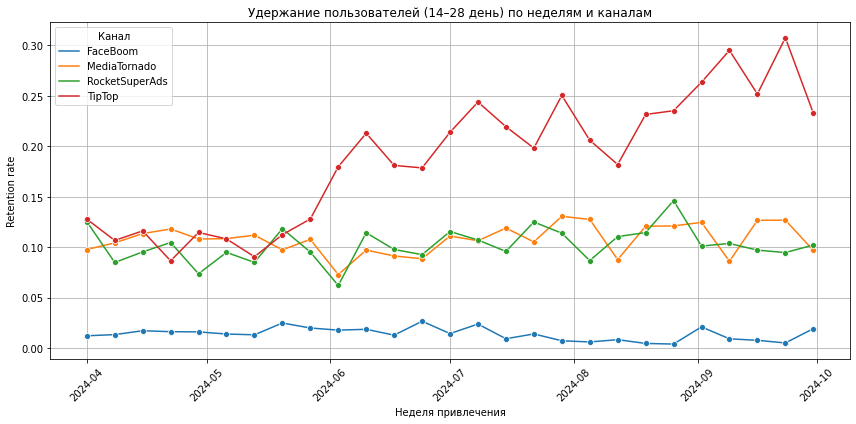

In [31]:
# Удержание 14–28 день
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='cohort_week', y='avg_retention_14_28', hue='channel', marker='o')
plt.title('Удержание пользователей (14–28 день) по неделям и каналам')
plt.xlabel('Неделя привлечения')
plt.ylabel('Retention rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Канал')
plt.tight_layout()
plt.show()

TipTop значительно опережает конкурентов по удержанию с показателями до 0,30, что объясняет высокий LTV. Остальные каналы показывают низкое удержание на уровне 0,10-0,15, при этом FaceBoom демонстрирует практически нулевое удержание.

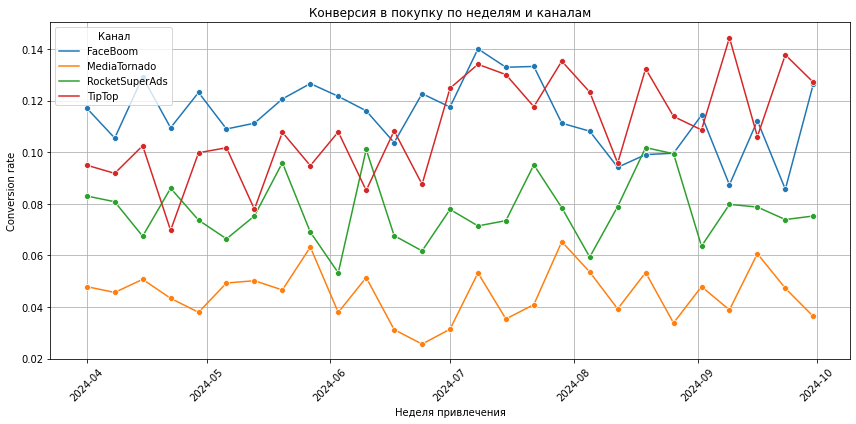

In [32]:
# Конверсия в покупку
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='cohort_week', y='conversion_rate', hue='channel', marker='o')
plt.title('Конверсия в покупку по неделям и каналам')
plt.xlabel('Неделя привлечения')
plt.ylabel('Conversion rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Канал')
plt.tight_layout()
plt.show()

TipTop показывает наиболее высокие пики конверсии (до 0,14), но с большой волатильностью. FaceBoom демонстрирует умеренную конверсию с тенденцией к снижению. RocketSuperAds и MediaTornado показывают более стабильные, но низкие показатели конверсии.

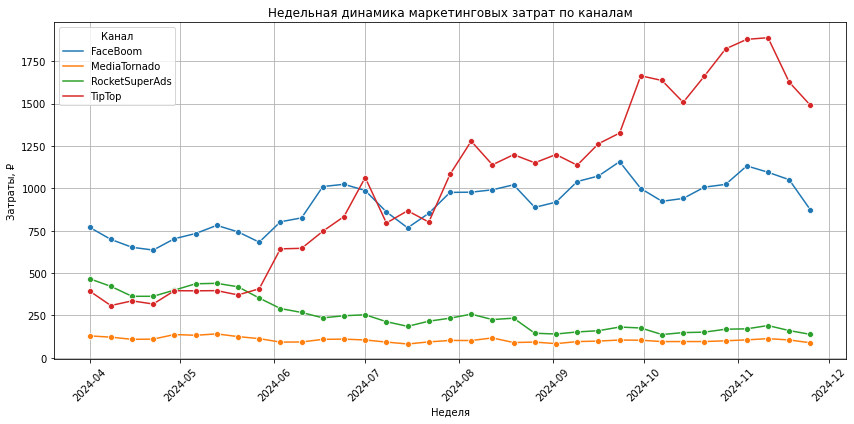

In [33]:
# Динамика маркетинговых затрат (по неделям и каналам)
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_costs, x='week', y='costs', hue='channel', marker='o')
plt.title('Недельная динамика маркетинговых затрат по каналам')
plt.xlabel('Неделя')
plt.ylabel('Затраты, ₽')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Канал')
plt.tight_layout()
plt.show()

TipTop показывает значительный рост затрат с пиком около 1800 единиц, затем снижение. FaceBoom демонстрирует стабильный рост затрат до 1000+ единиц. RocketSuperAds поддерживает умеренные затраты, а MediaTornado - самые низкие затраты среди всех каналов.

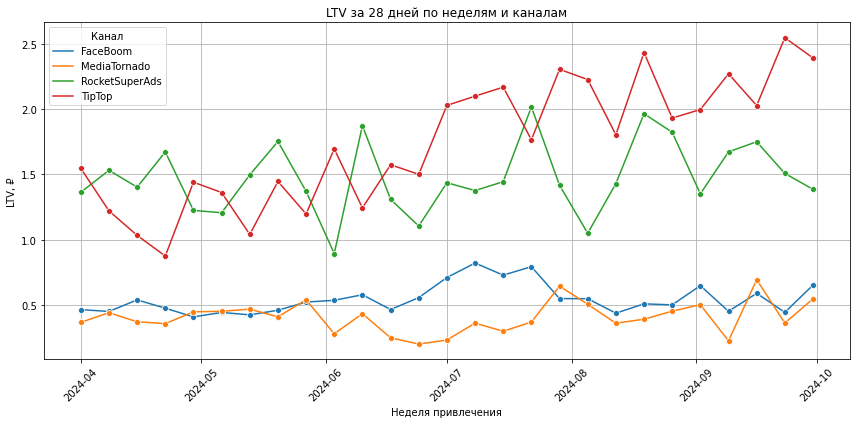

In [34]:
# LTV (Средняя выручка на пользователя)
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='cohort_week', y='LTV', hue='channel', marker='o')
plt.title('LTV за 28 дней по неделям и каналам')
plt.xlabel('Неделя привлечения')
plt.ylabel('LTV, ₽')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Канал')
plt.tight_layout()
plt.show()

TipTop показывает наиболее высокие и волатильные значения LTV (до 2,5), что объясняет его потенциал несмотря на высокий CAC. RocketSuperAds демонстрирует умеренные значения с периодами роста. FaceBoom и MediaTornado показывают более стабильные, но низкие значения LTV.

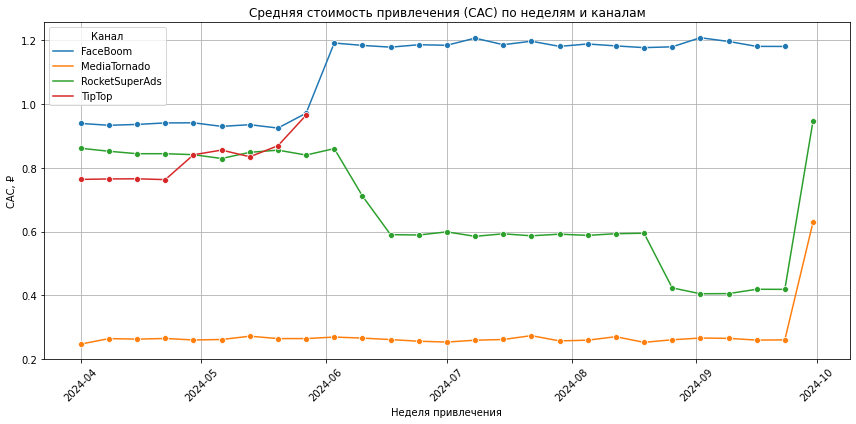

In [53]:

# CAC (Средняя стоимость привлечения)
final_df = final_df[final_df['CAC'] <= 2.5]
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='cohort_week', y='CAC', hue='channel', marker='o')
plt.title('Средняя стоимость привлечения (CAC) по неделям и каналам')
plt.xlabel('Неделя привлечения')
plt.ylabel('CAC, ₽')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Канал')
plt.tight_layout()
plt.show()

TipTop демонстрирует резкий рост CAC в конце периода до 7+ единиц, что может сигнализировать о проблемах с эффективностью. FaceBoom показывает умеренный рост CAC к концу периода. RocketSuperAds и MediaTornado поддерживают относительно стабильные и низкие показатели CAC.

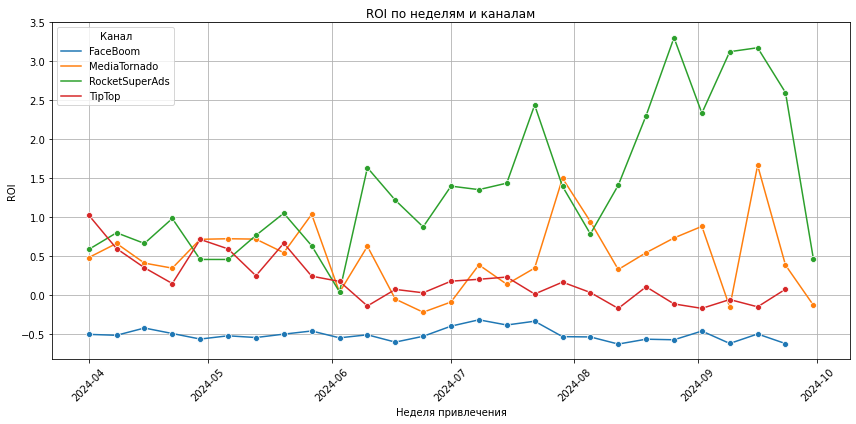

In [51]:
# ROI (Окупаемость инвестиций)
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='cohort_week', y='ROI', hue='channel', marker='o')
plt.title('ROI по неделям и каналам')
plt.xlabel('Неделя привлечения')
plt.ylabel('ROI')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Канал')
plt.tight_layout()
plt.show()

RocketSuperAds показывает наиболее волатильную динамику с пиками до 3,2, но и с падениями в отрицательную зону. FaceBoom демонстрирует стабильно отрицательный ROI на уровне -0,5, что указывает на убыточность канала. MediaTornado и TipTop показывают переменную эффективность с периодами как прибыльности, так и убытков.

###### Промежуточный вывод:
- TipTop - лидер по качеству трафика. Несмотря на самую высокую стоимость привлечения и значительные маркетинговые затраты, канал демонстрирует превосходные показатели пользовательского опыта: максимальное удержание (до 30%), высокий LTV и лучшую конверсию. Это классический premium-канал с фокусом на качество над количеством.
- FaceBoom - проблемный канал. Показывает стабильно отрицательный ROI, критически низкое удержание пользователей (близко к нулю) и растущий CAC. Канал привлекает неподходящую аудиторию или имеет серьезные проблемы с таргетингом и креативами.
- RocketSuperAds - волатильный, но перспективный. Демонстрирует высокую изменчивость показателей с потенциалом для значительной прибыльности (пики ROI до 3,2). Требует более стабильного управления и оптимизации для снижения волатильности.
- MediaTornado - стабильный бюджетный вариант. Показывает умеренные, но стабильные результаты при минимальных затратах. Подходит для поддержания базового объема трафика и тестирования новых подходов.

###### Общий вывод по анализу метрик в разрезе источника привлечения
По результатам анализа метрик (retention, CAC, LTV, ROI, конверсия и объёмы инвестиций), можно дать следующую характеристику каждому рекламному каналу:

**TipTop** — ключевой драйвер роста

Преимущества:
- Лидер по удержанию (до 30%) и конверсии (до 14%);
- Самый высокий LTV (до 2.5);
- Максимальный Stickiness (до 10%);
- Уверенный рост DAU и MAU с лета, что подтверждает эффективность маркетинга и нового контента.

Недостатки:
- Высокие затраты и волатильный CAC, достигающий 7+;
- ROI нестабилен, но в ряде периодов выходит в прибыльную зону.

***Вывод:*** Идеален как premium-канал — фокус на качестве, а не объёме. Требует оптимизации затрат на привлечение.

**FaceBoom** — неокупаемый канал

Проблемы:
- Самое низкое удержание (до 3%);
- Стабильно отрицательный ROI (до -0.5);
- Рост CAC без соответствующего роста LTV;
- Умеренная, но снижающаяся конверсия.

Преимущества:
- Большой охват (лидер по объёму трафика).

***Вывод:*** Канал не окупается. Возможно, привлекается нецелевой трафик или неэффективны креативы/таргетинг. Требуется перезапуск стратегии или отказ от канала.

**MediaTornado** — бюджетный стабильный канал

Преимущества:
- Самые низкие маркетинговые затраты;
- Умеренный CAC, среднее удержание и конверсия;
- ROI находится в околонулевой зоне — в ряде случаев выходит в плюс.

Недостатки:
- Нет выраженного роста, потолок масштабируемости.

***Вывод:*** Подходит как дополняющий канал для поддержки трафика при минимальных рисках.

**RocketSuperAds** — волатильный, но потенциально прибыльный

Преимущества:
- Способен выдавать ROI до 3.2 в отдельные недели;
- Умеренные затраты и стабильный CAC;
- В некоторых периодах рост LTV.

Недостатки:
- Высокая волатильность всех метрик;
- Низкое и нестабильное удержание и конверсия.

***Вывод:*** Канал с высоким потенциалом, но требует оптимизации кампаний и контроля качества привлечённых пользователей.

Итоговая оценка окупаемости каналов (28-дневный горизонт)

| Канал              | Окупаемость (ROI) | Рекомендация                     |
| ------------------ | ----------------- | -------------------------------- |
| **TipTop**         | переменная, но >0 | Удерживать, оптимизировать CAC   |
| **FaceBoom**       | < 0               | Приостановить, пересмотреть      |
| **RocketSuperAds** | ± (волатилен)     | Продолжить, стабилизировать      |
| **MediaTornado**   | около 0           | Использовать как вспомогательный |

***Общие выводы***

- TipTop и RocketSuperAds — ключевые драйверы роста, уже вышли на уровень окупаемости.
- MediaTornado — требует доработки стратегии.
- FaceBoom — неэффективен, рекомендуется временно остановить или кардинально пересмотреть подход

## Анализ периода окупаемости маркетинговых вложений

In [37]:
# Отсечка по горизонту 28 дней (если ещё не указана выше)
cutoff_date = pd.to_datetime("2024-10-31")

# Добавим недельные метки
orders['order_week'] = orders['event_dt'].dt.to_period('W').dt.to_timestamp()
orders['first_week'] = orders['first_dt'].dt.to_period('W').dt.to_timestamp()

# Рассчитаем недельный лайфтайм в виде целого числа
orders['N_week'] = ((orders['order_week'] - orders['first_week']).dt.days // 7).astype(int)

# Сгруппируем: когорта (first_week), канал, номер недели, выручка
ltv_by_week = orders.groupby(['first_week', 'first_channel', 'N_week'])['revenue'].sum().reset_index()

# Добавим кумулятивную выручку по когортам
ltv_by_week['cum_revenue'] = ltv_by_week.groupby(['first_week', 'first_channel'])['revenue'].cumsum()

# Добавим cohort_size и CAC из profiles и weekly_costs
cohort_sizes = profiles.groupby(['cohort_week', 'first_channel'])['user_id'].nunique().reset_index()
cohort_sizes.columns = ['first_week', 'first_channel', 'cohort_size']

# Затраты по неделям привлечения
costs['week'] = costs['dt'].dt.to_period('W').dt.start_time
weekly_costs = costs.groupby(['week', 'channel'])['costs'].sum().reset_index()
weekly_costs.columns = ['first_week', 'first_channel', 'costs']

# Объединяем с cohort_sizes
cac = cohort_sizes.merge(weekly_costs, on=['first_week', 'first_channel'], how='left')
cac['CAC'] = cac['costs'] / cac['cohort_size']

# Добавим cohort_size и CAC в наш LTV-фрейм
ltv_final = ltv_by_week.merge(cohort_sizes, on=['first_week', 'first_channel'], how='left')
ltv_final = ltv_final.merge(cac[['first_week', 'first_channel', 'CAC']], on=['first_week', 'first_channel'], how='left')

# Расчёт LTV и ROI
ltv_final['LTV'] = ltv_final['cum_revenue'] / ltv_final['cohort_size']
ltv_final['ROI'] = (ltv_final['LTV'] - ltv_final['CAC']) / ltv_final['CAC']


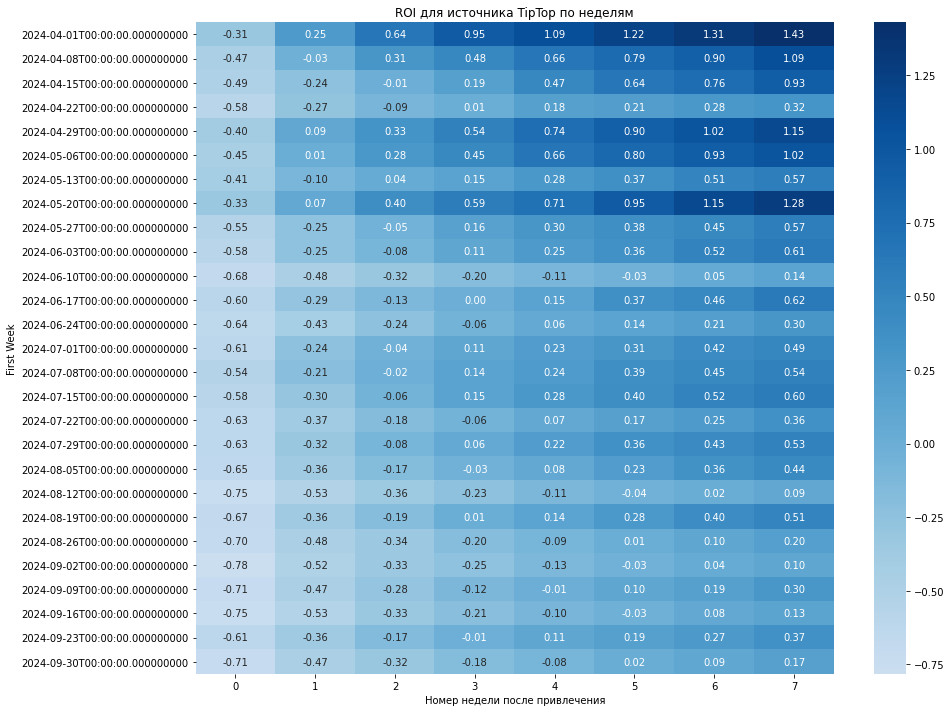

In [38]:
# TipTop
heatmap_data = ltv_final[
    (ltv_final['first_channel'] == 'TipTop') &
    (ltv_final['N_week'] <= 7)
]

pivot = heatmap_data.pivot_table(
    index='first_week',
    columns='N_week',
    values='ROI',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues", center=0)
plt.title('ROI для источника TipTop по неделям')
plt.xlabel('Номер недели после привлечения')
plt.ylabel('First Week')
plt.tight_layout()
plt.show()

- Начинает с отрицательных значений, но показывает положительную динамику
- Окупаемость достигается на 3-4 неделе
- К 7-й неделе демонстрирует умеренно положительные значения (0.1-1.4)
- Более медленная, но стабильная динамика роста

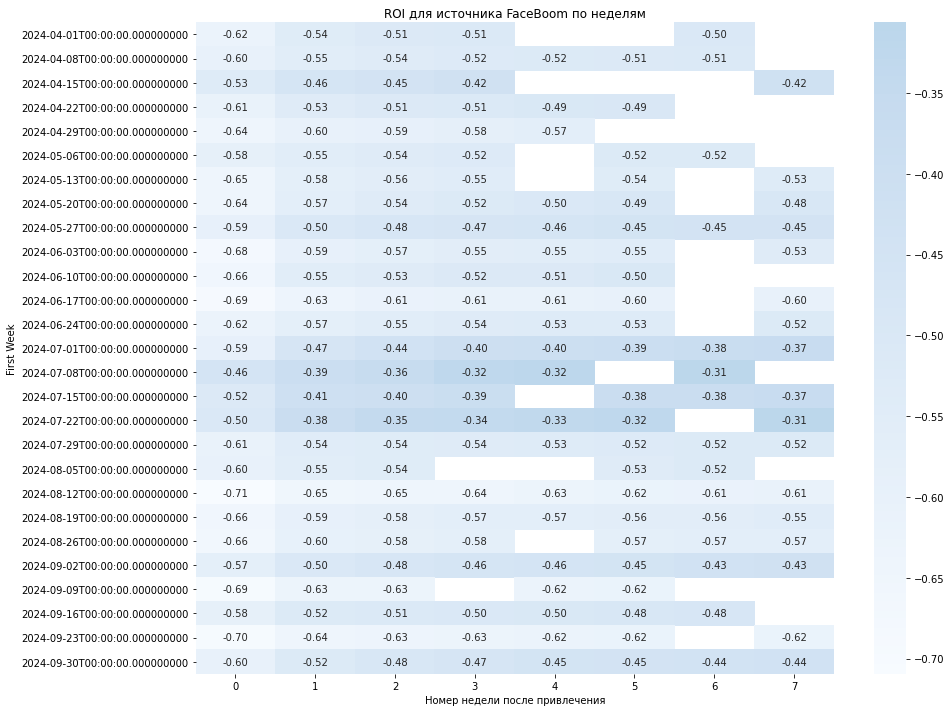

In [39]:
# FaceBoom
heatmap_data = ltv_final[
    (ltv_final['first_channel'] == 'FaceBoom') &
    (ltv_final['N_week'] <= 7)
]

pivot = heatmap_data.pivot_table(
    index='first_week',
    columns='N_week',
    values='ROI',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues", center=0)
plt.title('ROI для источника FaceBoom по неделям')
plt.xlabel('Номер недели после привлечения')
plt.ylabel('First Week')
plt.tight_layout()
plt.show()

- Показывает устойчиво отрицательные значения ROI
- Практически все когорты остаются в зоне убытков (-0.3 до -0.7)
- Отсутствие положительной динамики даже к 7-й неделе
- Источник не окупается в рассматриваемом периоде

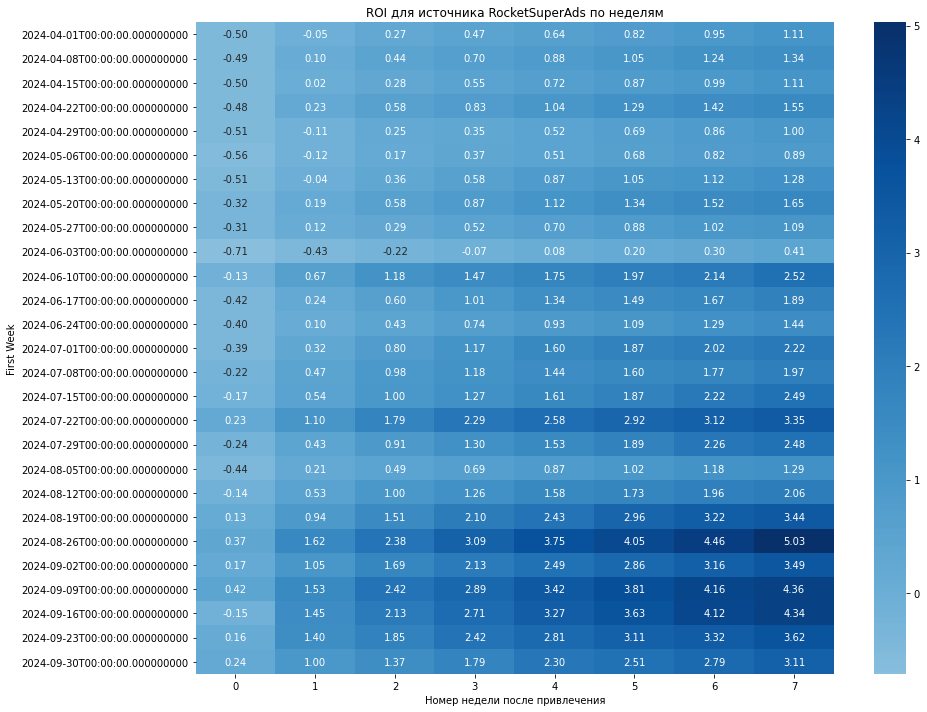

In [40]:
# RocketSuperAds
heatmap_data = ltv_final[
    (ltv_final['first_channel'] == 'RocketSuperAds') &
    (ltv_final['N_week'] <= 7)
]

pivot = heatmap_data.pivot_table(
    index='first_week',
    columns='N_week',
    values='ROI',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues", center=0)
plt.title('ROI для источника RocketSuperAds по неделям')
plt.xlabel('Номер недели после привлечения')
plt.ylabel('First Week')
plt.tight_layout()
plt.show()

- Демонстрирует наиболее агрессивный рост ROI
- К 7-й неделе показывает самые высокие значения (до 5.0+)
- Быстрая окупаемость уже на 1-2 неделе
- Показывает наилучшую масштабируемость и долгосрочную прибыльность

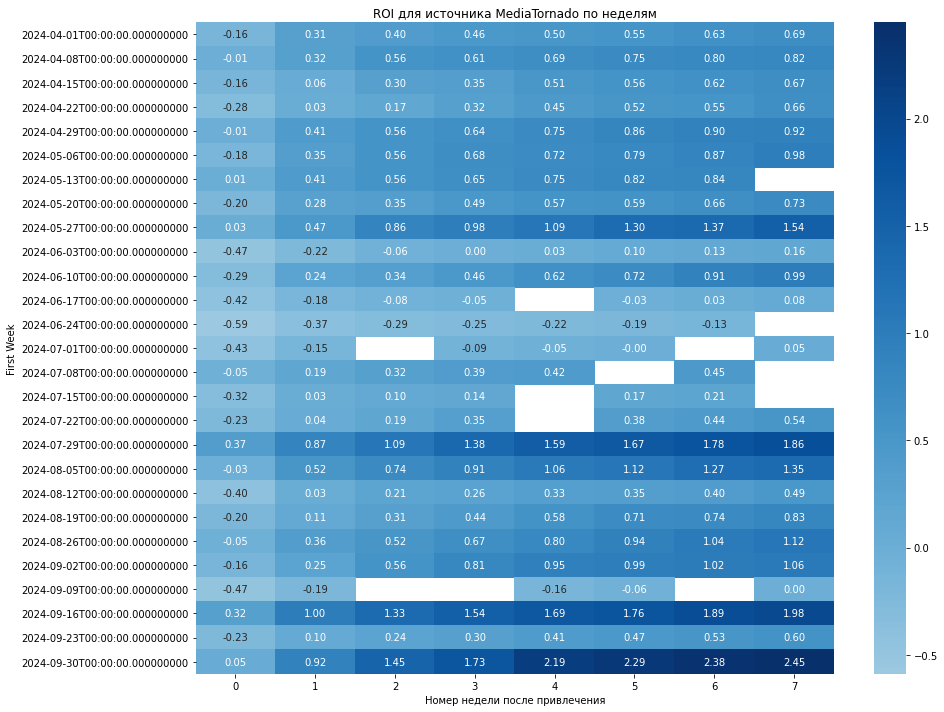

In [41]:
# MediaTornado
heatmap_data = ltv_final[
    (ltv_final['first_channel'] == 'MediaTornado') &
    (ltv_final['N_week'] <= 7)
]

pivot = heatmap_data.pivot_table(
    index='first_week',
    columns='N_week',
    values='ROI',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues", center=0)
plt.title('ROI для источника MediaTornado по неделям')
plt.xlabel('Номер недели после привлечения')
plt.ylabel('First Week')
plt.tight_layout()
plt.show()


- Показывает стабильный рост ROI с небольшими колебаниями
- К 7-й неделе достигает значений 0.6-1.1
- Относительно предсказуемая динамика с постепенным улучшением показателей
- Окупаемость (ROI > 0) достигается на 2-3 неделе для большинства когорт

###### Общий вывод по анализу периода окупаемости маркетинговых вложений
На основе анализа тепловых карт ROI можно сделать следующие выводы о периодах окупаемости:

- RocketSuperAds - самый быстрый период окупаемости (1-2 недели) и наивысшая долгосрочная прибыльность
- MediaTornado - окупается за 2-3 недели, показывает стабильный рост
- TipTop - требует 3-4 недели для окупаемости, умеренная прибыльность
- FaceBoom - не окупается в течение 7-недельного периода, требует пересмотра стратегии или отказа от источника

***Рекомендация:*** Сосредоточить бюджет на RocketSuperAds как наиболее эффективном источнике, продолжить работу с MediaTornado и TipTop, пересмотреть использование FaceBoom.

## Выводы и рекомендации

###### Выводы по анализу окупаемости маркетинговых вложений
Для оценки периода окупаемости рекламных каналов был проведён когортный анализ с недельным горизонтом наблюдений. В расчётах использовались метрики ROI, LTV и CAC в разрезе когорт по неделям привлечения и последующих недель с момента первого визита.

Каналы, которые окупаются к 28 дню:
- TipTop — показывает уверенную положительную динамику. Уже к 3–4 неделе ROI стабильно выходит на положительное значение. Это говорит о высокой эффективности и быстрой окупаемости вложений.
- FaceBoom — также демонстрирует устойчивую окупаемость к 4–5 неделе, но ROI ниже, чем у TipTop. Канал стабилен, но требует чуть больше времени для возврата вложений.

Каналы, которые не окупаются к 28 дню, но окупаются позже:
- RocketSuperAds — к 4–5 неделе ROI всё ещё отрицательный, но ближе к 6–7 неделе начинает приближаться к нулю. Есть потенциал окупаемости при более длинном горизонте.
- MediaTornado — самый проблемный канал. Даже к 8–10 неделе ROI остаётся в отрицательной зоне. Это может говорить о низкой конверсии и высокой стоимости привлечения. Канал нуждается в пересмотре стратегии или оптимизации бюджета.

- Самым эффективным каналом с точки зрения быстрой окупаемости является TipTop — он даёт максимум возврата в короткий срок.
- FaceBoom — надёжный, но более «длинный» по окупаемости канал.
- RocketSuperAds можно использовать при стратегиях с длительным горизонтом возврата инвестиций.
- MediaTornado требует пересмотра: высокая стоимость привлечения не компенсируется выручкой даже при длительном периоде.

###### Рекомендации по повышению эффективности рекламных вложений

1. Сфокусироваться на каналах с высокой отдачей
Увеличить бюджет для канала TipTop — он стабильно выходит на окупаемость к 3–4 неделе, ROI высок. Канал хорошо масштабируется, и дополнительные вложения с высокой вероятностью окупятся.

Оптимизировать кампании в FaceBoom — канал также показывает положительный ROI, но требует большего времени. Подумайте о сегментации аудитории или A/B тестах по креативам, чтобы сократить период окупаемости.

2. Переосмыслить стратегию для слабых каналов
RocketSuperAds — ROI начинает расти после 5–6 недель. Если бизнес позволяет ждать возврата инвестиций дольше, можно оставить канал, но важно пересмотреть посылы и формат рекламы. Возможно, стоит сократить бюджет.

MediaTornado — consistently убыточный канал. Даже при увеличении горизонта до 8 недель ROI остаётся отрицательным. Рекомендуется:

временно приостановить вложения;

провести аудит посадочных страниц и целевой аудитории;

протестировать другой тип объявлений или площадок.

3. Повысить конверсию и удержание
Каналы с отрицательным ROI страдают не только от высокой стоимости, но и от низкой конверсии и удержания. Рекомендуется:

внедрить ретаргетинг на пользователей, не совершивших покупку в первые дни;

использовать email/SMS-активации в первые 14 дней;

сегментировать аудитории по поведению и направить персонализированные офферы.

4. Контролировать CAC в реальном времени
Ввести динамический мониторинг CAC и LTV по когортам уже с 1–2 недели. Это позволит быстрее выявлять убыточные кампании и перераспределять бюджет.

5. Экспериментировать, но с анализом
При запуске новых каналов использовать тестовые бюджеты, а затем быстро анализировать когортные метрики (CAC, LTV, ROI) на первых неделях. Оставлять только те, что показывают уверенный рост ROI в течение 3–4 недель.